## Prototype of a real-time phase estimation algorithm
### detect the critical points of the oscillatory signal and map the cycle onto sample count

In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.signal import hilbert

In [2]:
regr = LinearRegression()

In [3]:
central_freq = 1
sampling_rate = 1500
# slope = 2*pi / # of corresponding sample counts
default_slope = (2*np.pi)/(sampling_rate/central_freq)
# ignoring the computation time, 62 samples every quarter cycle

num_to_wait = 5
buffer_size = 20

In [4]:
t = np.linspace(0, 10, sampling_rate*10)
# x = np.sin(2*np.pi*t) + 2*np.sin(4*np.pi*t) + 3*np.sin(20*np.pi*t)\n
x = np.sin(2*np.pi*central_freq*t)

derivative_history = []

### stepwise derivative

In [5]:
sample_axis = np.arange(buffer_size).reshape(-1,1)
for i in range(buffer_size,len(t)):
    current_buffer = x[i-buffer_size:i]
    regr.fit(sample_axis,current_buffer)
    derivative_history.append(regr.coef_)

In [6]:
for i in range(len(derivative_history)):
    derivative_history[i] = derivative_history[i][0]

<IPython.core.display.Javascript object>


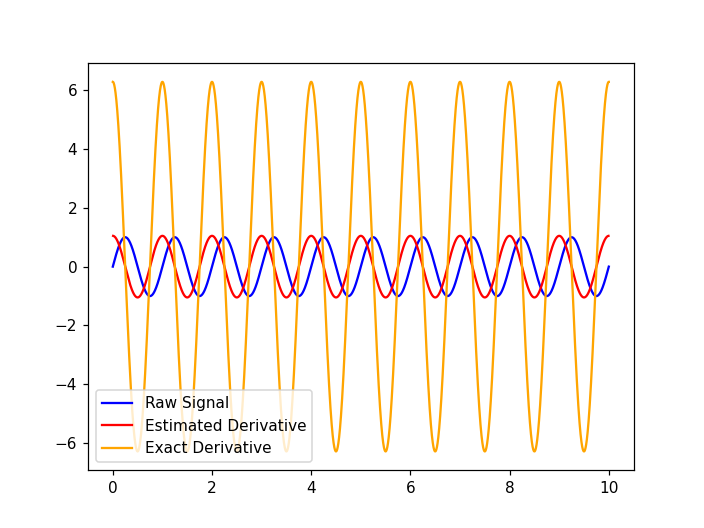

In [7]:
%matplotlib notebook

plt.plot(t,x,color='b',label='Raw Signal')
plt.plot(t[int(buffer_size/2):int(len(t)-buffer_size/2)],np.array(derivative_history)*250,'r',label='Estimated Derivative')
# more generally, exact derivative should be obtained with numpy.gradient() method
plt.plot(t,(central_freq)*2*np.pi*np.cos((central_freq)*2*np.pi*t),color='orange',label='Exact Derivative')
plt.legend()

### critical point detection

In [8]:
critical_time = []
current_sign = True
sign_buffer = []

# the starting point case is really tricky here

for i in range(len(derivative_history)):
    if i == 0:
        current_sign = (derivative_history[0]>0)
        sign_buffer = [derivative_history[0]>0]*num_to_wait
        continue
    sign_buffer.append(derivative_history[i]>0)
    sign_buffer.pop(0)
        
    flip = True
    for sign in sign_buffer:
        if current_sign == sign:
            flip = False
            
    if flip:
        critical_time.append(t[i+int(buffer_size/2)-num_to_wait])
        current_sign = sign_buffer[-1]

<IPython.core.display.Javascript object>


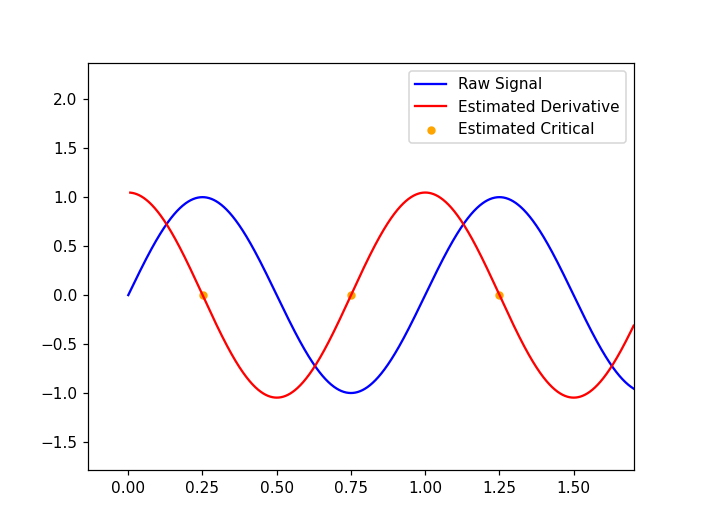

In [19]:
%matplotlib notebook

plt.plot(t,x,color='b',label='Raw Signal')
plt.plot(t[int(buffer_size/2):int(len(t)-buffer_size/2)],np.array(derivative_history)*250,'r',label='Estimated Derivative')
plt.scatter(critical_time,[0]*len(critical_time),s=20,color='orange',label='Estimated Critical')
plt.legend()

### Slope update

In [10]:
slope_history = [default_slope]

for i in range(1,len(critical_time)):
    current_interval = (critical_time[i] - critical_time[i-1])*sampling_rate
    current_slope = np.pi/current_interval
    slope_history.append(current_slope)

In [11]:
if len(critical_time) == len(slope_history):
    test = dict(zip(critical_time,slope_history))

### Phase interpolation

#### again, starting point is a tricky problem for interpolation .. need to know initial phase position. What about phase resets? Won't be able to know initial phase position then

In [33]:
initial_phase = None

# if the derivative starts positive, the next critical point should be pi/2; otherwise it's (3/2)pi

if derivative_history[0]>0:
    # initial_phase = np.pi/2
    initial_phase = np.pi
else:
    # initial_phase = (3/2)*np.pi
    initial_phase = 0

In [34]:
phase_history = [initial_phase]
last_critical_point = 0
current_slope = default_slope

for time in t:
    
    if time <= critical_time[0]: continue
        
    # update current_slope upon passing each critical point
    try:
        if time > critical_time[last_critical_point+1]:
            last_critical_point = last_critical_point+1
            current_slope = test[critical_time[last_critical_point]]
    # for the last segment, last_critical_point + 1 would make index out of bound
    except IndexError:
        current_slope = test[critical_time[-1]]
        
    
    # calculate current phase based on current slope
    # multiply total_time_elapsed by sampling rate because the slope is phase vs. sample count
    current_phase = (initial_phase+(time-critical_time[0])*sampling_rate*current_slope) % (2*np.pi)
    phase_history.append(current_phase)

<IPython.core.display.Javascript object>


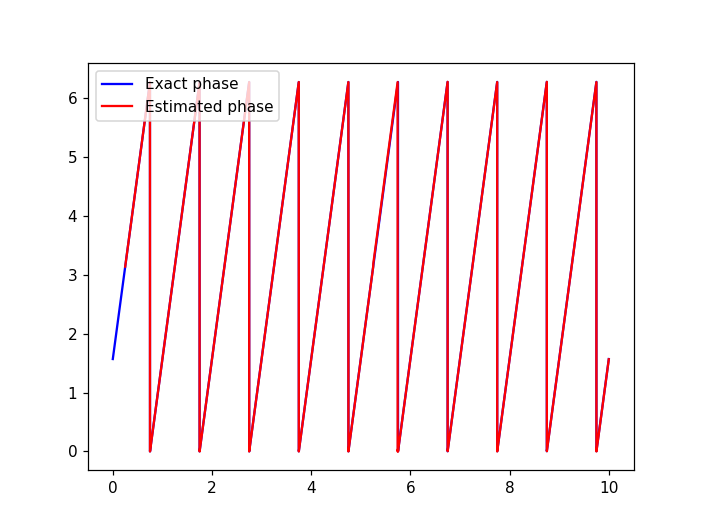

In [37]:
%matplotlib notebook

phase_detection_start = 0
for i in range(len(t)):
    if critical_time[0] == t[i]:
        phase_detection_start = i
        break

exact_phase = np.angle(hilbert(x))+np.pi
        
plt.plot(t,exact_phase,color='b',label='Exact phase')
plt.plot(t[phase_detection_start:],phase_history,color='r',label='Estimated phase')
plt.legend()

### Analysis

In [43]:
# Mean squared error (rad)
MSE = np.square(np.subtract(exact_phase[phase_detection_start:],phase_history)).mean()
MSE

0.03476835207984465